# Model Building

in this notebook, we will build a CNN model with transfer learning such as VGG16, ResNet50 or 101, ect. we want to reach a high accuracy something near to 99%. 

Notebook agenda:
- imporint the libraries
- EDA
- pre-processing (like resize images, data augmentation)
- model and transfer learning
- create a function for bounded box
- evaluate the model

In [1]:
from matplotlib import patches
# from skimage import data, io
# from skimage.feature import Cascade
# from skimage.transform import resize
import pathlib
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import pickle

In [2]:
os.getcwd()

'd:\\IAU\\5 - year\\Second semester\\Computer vision\\System\\FacialRecognition'

In [3]:
%cd Dataset

d:\IAU\5 - year\Second semester\Computer vision\System\FacialRecognition\Dataset


In [4]:
path = pathlib.Path(os.getcwd())

In [5]:
path

WindowsPath('d:/IAU/5 - year/Second semester/Computer vision/System/FacialRecognition/Dataset')

In [6]:
%cd .. 

d:\IAU\5 - year\Second semester\Computer vision\System\FacialRecognition


In [7]:
images = list(path.glob('Unknown/*.jpg'))

In [8]:
len(images)

250

In [9]:
images[0]

WindowsPath('d:/IAU/5 - year/Second semester/Computer vision/System/FacialRecognition/Dataset/Unknown/0 (10).jpg')

In [10]:
img = cv2.imread(str(images[0]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

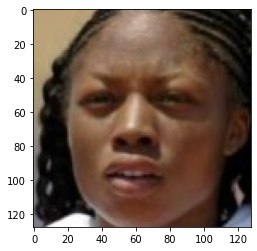

In [11]:
plt.imshow(img)

In [12]:
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [13]:
faces = face_cascade.detectMultiScale(
        img,
        scaleFactor=1.3,
        minNeighbors=5,
        minSize=(100, 100),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

In [14]:
len(faces)

1

In [15]:
faces

array([[  6,   8, 116, 116]])

In [16]:
def show_detected_images(img, detected, title='Faces', k = 0.1):
    plt.figure(figsize=(12,10))
    img_cv = cv2.imread(str(img))
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    start_x = 0
    start_y = 0

    for (x, y, w, h) in faces:
        if x - k*w > 0:
            start_x = int(x - k*w)
        else:
            start_x = x
        if y - k*h > 0:
            start_y = int(y - k*h)
        else:
            start_y = y

        end_x = int(x + (1 + k)*w)
        end_y = int(y + (1 + k)*h)

        face_image = img_cv[start_y:end_y,
                        start_x:end_x]
        face_image = cv2.resize(face_image, [150, 150])
        # face_image = np.expand_dims(face_image, axis=0)
        cv2.rectangle(img_cv,
                      (x, y),  # start_point
                      (x+w, y+h),  # end_point
                      (0,255,0),
                      2)  # thickness in px

    # display the resulting frame
    cv2.imshow("Face detector - to quit press ESC", img_cv)
    key = cv2.waitKey(1)
    if key % 256 == 27:  # ESC code
        pass
    cv2.destroyAllWindows()

In [17]:
show_detected_images(images[0], faces)

<Figure size 864x720 with 0 Axes>

In [18]:
faces_path = {
    'Unknown': list(path.glob('Unknown/*.jpg')),
    'Basheer':list(path.glob('Basheer/*.jpg')),
    'Omran':list(path.glob('Omran/*.jpg')),
    'Faisal':list(path.glob('Faisal/*.jpg'))
}

faces_labels = {
    'Unknown':0,
    'Basheer': 1,
    'Omran':2,
    'Faisal':3
}

In [19]:
x = []
y = []
k = 0.1
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for faces_name, faces in faces_path.items():
    for face in faces:
        img_cv = cv2.imread(str(face))
        img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
        detected = face_cascade.detectMultiScale(
                                                    img_cv,
                                                    scaleFactor=1.3,
                                                    minNeighbors=10,
                                                    minSize=(100, 100),
                                                    flags=cv2.CASCADE_SCALE_IMAGE
                                                )
        if len(detected) > 0:
             for (x_cor, y_cor, w, h) in detected:
                if x_cor - k*w > 0:
                    start_x = int(x_cor - k*w)
                else:
                    start_x = x_cor
                if y_cor - k*h > 0:
                    start_y = int(y_cor - k*h)
                else:
                    start_y = y_cor

                end_x = int(x_cor + (1 + k)*w)
                end_y = int(y_cor + (1 + k)*h)
                face_image = img_cv[start_y:end_y,
                            start_x:end_x]
                face_image = cv2.resize(face_image, (150, 150))
                x.append(face_image)
                y.append(faces_labels[faces_name])

In [20]:
len(x)

29

In [21]:
with open('x.pickle', 'wb') as f:
    pickle.dump(x,f)

with open('y.pickle', 'wb') as f:
    pickle.dump(y,f)

In [22]:
# with open('x.pickle', 'rb') as f:
#     x = pickle.load(f)

# with open('y.pickle', 'rb') as f:
#     y = pickle.load(f)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, stratify=y, random_state=5)

In [24]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model

In [26]:
# model = Sequential()
# model.add(Conv2D(filters=128, kernel_size = 3, padding = 'same', activation= 'relu' ))
# model.add(Conv2D(filters=256, kernel_size = 3, padding = 'same', activation= 'relu' ))
# model.add(MaxPooling2D(pool_size = 2))
# model.add(Flatten())
# model.add(Dense(units = 1, activation='sigmoid'))

In [27]:
# opt = Adam()
# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# # es = EarlyStopping(mode='min', monitor='val_loss', patience=15)
# mc = ModelCheckpoint(filepath='./model', monitor='val_loss', mode='min', save_best_only=True)

In [28]:
# model.fit(x_train, y_train, epochs=5, batch_size=8, callbacks=[mc], validation_data=(x_test, y_test))

ResNet50

In [29]:
from tensorflow.keras.applications.resnet import ResNet50

In [30]:
resnet = ResNet50(include_top=False, input_shape=(150, 150, 3), weights='imagenet')

ImportError: `load_weights` requires h5py package when loading weights from HDF5. Try installing h5py.

In [ ]:
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
inputs = Input(shape=(150, 150, 3))
x = resnet(inputs, training=False)
x = Flatten()(x)
out = Dense(units = 4, activation = 'softmax')(x)

res_model = Model(inputs, out)

In [ ]:
opt = Adam()
res_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(mode='min', monitor='val_loss', patience=15, restore_best_weights = True)
# mc = ModelCheckpoint(filepath='./res_model', monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
res_model.fit(x_train, y_train, epochs=5, batch_size=32, callbacks=[es], validation_data=(x_test, y_test))

In [ ]:
res_model.save('modelv2.h5')

In [ ]:
res_model = load_model('modelv2.h5')

ImportError: Filepath looks like a hdf5 file but h5py is not available. filepath=modelv2.h5

In [ ]:
def detect_faces(frame):
    face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    detected_face = face_cascade.detectMultiScale(
        frame,
        scaleFactor=1.3,
        minNeighbors=5,
        minSize=(100, 100),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    return detected_face

In [ ]:
def get_extended_image(img, x, y, w, h, k=0.1):
    if x - k*w > 0:
        start_x = int(x - k*w)
    else:
        start_x = x
    if y - k*h > 0:
        start_y = int(y - k*h)
    else:
        start_y = y

    end_x = int(x + (1 + k)*w)
    end_y = int(y + (1 + k)*h)

    face_image = img[start_y:end_y,
                     start_x:end_x]
    face_image = cv2.resize(face_image, (150, 150))
    face_image = np.expand_dims(face_image, axis=0)
    return face_image

In [ ]:
def prediction(face):
    classes = ['Unknown','Mohammed','Omran','Faisal']
    y_pred = res_model.predict(face)
    y_pred_class = classes[np.array(y_pred[0].argmax(axis = 0))]
    confidence = np.array(y_pred[0]).max(axis=0)

    return y_pred_class, confidence

In [ ]:
cap = cv2.VideoCapture(0)

while True:
    succ, frame = cap.read()

    if not succ:
        break

    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    detected_face = detect_faces(frame)

    if len(detected_face) > 0:
        for (x, y, w, h) in detected_face:
            face_image = get_extended_image(frame, x, y, w, h, 0.5)

            class_name, conf = prediction(face_image)

            cv2.rectangle(frame,
                        (x, y),  # start_point
                        (x+w, y+h),  # end_point
                        (0,255,0),
                        2)  # thickness in px
            cv2.putText(frame,
                        # text to put
                        f"{class_name} - {conf*100}%",
                        (x, y),
                        cv2.FONT_HERSHEY_PLAIN,  # font
                        2,  # fontScale
                        (0,255,0),
                        2)  # thickness in px

    cv2.imshow("Face detector - to quit press ESC", frame)

    # Exit with ESC
    key = cv2.waitKey(1)
    if key % 256 == 27:  # ESC code
        break


# when everything done, release the capture
cap.release()
cv2.destroyAllWindows()